#### Copyright 2018 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cat vs. Dog Image Classification
## Exercise 3: Feature Extraction and Fine-Tuning
**_Estimated completion time: 30 minutes_**

In Exercise 1, we built a convnet from scratch, and were able to achieve an accuracy of about 70%. With the addition of data augmentation and dropout in Exercise 2, we were able to increase accuracy to about 80%. That seems decent, but 20% is still too high of an error rate. Maybe we just don't have enough training data available to properly solve the problem. What other approaches can we try?

In this exercise, we'll look at two techniques for repurposing feature data generated from image models that have already been trained on large sets of data, **feature extraction** and **fine tuning**, and use them to improve the accuracy of our cat vs. dog classification model.

## Feature Extraction Using a Pretrained Model

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This versatility and repurposability of convnets is one of the most interesting aspects of deep learning.

In our case, we will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) developed at Google, and pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of Inception V3 we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Inception V3 model preloaded with weights trained on ImageNet:


In [1]:
import os
import tensorflow as tf

from keras.applications.inception_v3 import InceptionV3
from keras import layers
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K

# Configure the TF backend session
tf_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))

Using TensorFlow backend.


Now let's download the weights:

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2018-06-21 03:05:40--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.6.80, 2607:f8b0:400a:806::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.6.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  51.5MB/s    in 1.6s    

2018-06-21 03:05:42 (51.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [24]:
#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#pre_trained_model = InceptionV3(
#    input_shape=(256, 256, 3), include_top=False, weights='imagenet')
#pre_trained_model.load_weights(local_weights_file)
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [20]:
for layer in conv_base.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [22]:
last_layer = pre_trained_model.get_layer('mixed7')
print 'last layer output shape:', last_layer.output_shape
last_output = conv_base.output

last layer output shape: (None, 14, 14, 768)


In [23]:
conv_base.output

<tf.Tensor 'block5_pool_2/MaxPool:0' shape=(?, 4, 4, 512) dtype=float32>

Now let's stick a fully connected classifier on top of `last_output`:

In [81]:
def create_model(dr = 0.4, mnorm=1):
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(conv_base)
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(dr)(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)

    # Configure and compile the model
    model = Model(pre_trained_model.input, x)
    model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])
    return model


For examples and data preprocessing, let's use the same files and `train_generator` as we did in Exercise 2.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [7]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2018-06-21 03:06:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.6.80, 2607:f8b0:400a:806::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.6.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  39.7MB/s    in 1.6s    

2018-06-21 03:06:12 (39.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [13]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [30]:
import os
import zipfile
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
# local_zip = '/tmp/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

# Define our example directories and files
# base_dir = '/tmp/cats_and_dogs_filtered'
base_dir = '/mnt/data/datasets/tvt'

train_dir = os.path.join(base_dir, 'chnmcu256train')
validation_dir = os.path.join(base_dir, 'chnmcu256validate')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 10)
validation_features, validation_labels = extract_features(validation_dir, 10)
#test_features, test_labels = extract_features(test_dir, 1000)




Found 58800 images belonging to 2 classes.
Found 9800 images belonging to 2 classes.


In [73]:
train_features = np.reshape(train_features, (10, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (10, 4 * 4 * 512))

In [85]:
train_features.shape

(10, 8192)

In [86]:
train_labels.shape

(10, 1)

In [43]:
from keras.utils.np_utils import to_categorical 
train_labels2 = to_categorical(train_labels, num_classes = 2)

In [53]:
type(train)

pandas.core.frame.DataFrame

In [70]:
import pandas as pd
index = ['Row'+str(i) for i in range(1, len(train_labels)+1)]
train_labels=pd.DataFrame(train_labels, index=index)



In [74]:
index = ['Row'+str(i) for i in range(1, len(train_features)+1)]
train_features=pd.DataFrame(train_features, index=index)

In [77]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
Row1,0.383093,0.0,0.0,0.027723,0.000000,0.0,0.300637,0.078064,0.0,0.0,...,1.448683,0.189380,0.550789,0.0,0.0,0.656865,0.000000,0.0,0.895589,0.0
Row2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,2.435227,0.435063,0.437344,0.0,0.0,1.608941,0.328367,0.0,0.005533,0.0
Row3,0.232377,0.0,0.0,0.000000,0.023135,0.0,0.000000,0.000000,0.0,0.0,...,1.942467,0.049051,0.217033,0.0,0.0,0.306430,0.000000,0.0,0.828010,0.0
Row4,0.684580,0.0,0.0,0.000000,0.185215,0.0,0.000000,0.000000,0.0,0.0,...,2.708882,0.203213,0.144261,0.0,0.0,0.137167,0.806900,0.0,0.354845,0.0
Row5,0.590848,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,1.778891,0.627145,0.241130,0.0,0.0,0.904722,0.000000,0.0,0.139114,0.0


In [82]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


model = KerasClassifier(build_fn=create_model,epochs=2, batch_size=100, verbose=1)
# define the grid search parameters
dr = [0.4, 0.44]
param_grid = dict(dr=dr)

In [83]:
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [88]:
#grid_result = grid.fit(train_features,train_labels)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [23]:
validation_features.shape()

NameError: name 'validation_features' is not defined

Finally, let's train the model using the features we extracted. We'll train on all 2000 images available, for 2 epochs, and validate on all 1,000 test images.

In [10]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/10
 - 12s - loss: 0.8737 - acc: 0.6960 - val_loss: 0.5467 - val_acc: 0.7240
Epoch 2/10
 - 8s - loss: 0.5373 - acc: 0.7730 - val_loss: 0.4916 - val_acc: 0.7850
Epoch 3/10
 - 8s - loss: 0.4520 - acc: 0.8040 - val_loss: 0.4857 - val_acc: 0.7870
Epoch 4/10
 - 8s - loss: 0.4095 - acc: 0.8270 - val_loss: 0.9548 - val_acc: 0.6800
Epoch 5/10
 - 8s - loss: 0.3826 - acc: 0.8470 - val_loss: 1.0877 - val_acc: 0.6640
Epoch 6/10
 - 8s - loss: 0.3327 - acc: 0.8605 - val_loss: 0.4976 - val_acc: 0.8110
Epoch 7/10
 - 8s - loss: 0.3166 - acc: 0.8805 - val_loss: 0.4368 - val_acc: 0.8350
Epoch 8/10
 - 8s - loss: 0.2895 - acc: 0.8860 - val_loss: 0.5632 - val_acc: 0.8110
Epoch 9/10
 - 8s - loss: 0.2781 - acc: 0.8895 - val_loss: 0.4798 - val_acc: 0.8240
Epoch 10/10
 - 8s - loss: 0.2730 - acc: 0.8945 - val_loss: 0.5792 - val_acc: 0.8210


You can see that we reach a validation accuracy of 88–90% very quickly. This is much better than the small model we trained from scratch.

## Further Improving Accuracy with Fine-Tuning

In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:

- **Fine-tuning should only be attempted *after* you have trained the top-level classifier with the pretrained model set to non-trainable**. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
- Additionally, we **fine-tune only the *top layers* of the pre-trained model** rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the `mixed7` module—i.e., all layers found after `mixed6`—and recompile the model:

In [11]:
unfreeze = True

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

from keras.optimizers import SGD

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=0.00001, momentum=0.9),
              metrics=['acc'])

Now let's retrain the model. We'll train on all 2000 images available, for 50 epochs, and validate on all 1,000 test images. (This may take 15-20 minutes to run.)

In [12]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/20
 - 20s - loss: 0.1707 - acc: 0.9320 - val_loss: 0.5704 - val_acc: 0.8050
Epoch 2/20
 - 16s - loss: 0.1846 - acc: 0.9305 - val_loss: 0.5442 - val_acc: 0.8130
Epoch 3/20
 - 16s - loss: 0.1654 - acc: 0.9410 - val_loss: 0.4827 - val_acc: 0.8320
Epoch 4/20
 - 16s - loss: 0.1618 - acc: 0.9385 - val_loss: 0.5785 - val_acc: 0.8040
Epoch 5/20
 - 16s - loss: 0.1416 - acc: 0.9480 - val_loss: 0.4639 - val_acc: 0.8390
Epoch 6/20
 - 16s - loss: 0.1442 - acc: 0.9455 - val_loss: 0.6695 - val_acc: 0.7630
Epoch 7/20
 - 16s - loss: 0.1599 - acc: 0.9395 - val_loss: 0.4969 - val_acc: 0.8180
Epoch 8/20
 - 16s - loss: 0.1711 - acc: 0.9280 - val_loss: 0.5061 - val_acc: 0.8100
Epoch 9/20
 - 16s - loss: 0.1322 - acc: 0.9525 - val_loss: 0.5108 - val_acc: 0.8130
Epoch 10/20
 - 16s - loss: 0.1409 - acc: 0.9455 - val_loss: 0.5430 - val_acc: 0.8150
Epoch 11/20
 - 16s - loss: 0.1554 - acc: 0.9395 - val_loss: 0.5802 - val_acc: 0.8070
Epoch 12/20
 - 16s - loss: 0.1194 - acc: 0.9550 - val_loss: 0.5801 - val_a

We are seeing a nice improvement, with the validation loss going from ~1.7 down to ~1.2, and accuracy going from 88% to 92%. That's a 4.5% relative improvement in accuracy.

Let's plot the training and validation loss and accuracy to show it conclusively:

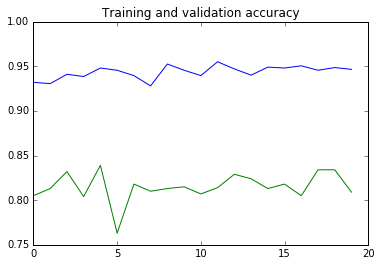

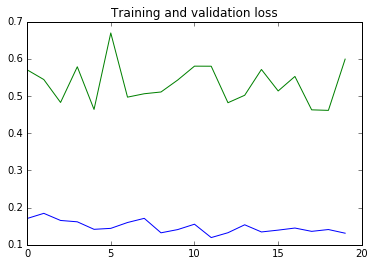

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Congratulations! Using feature extraction and fine-tuning, you've built an image classification model that can identify cats vs. dogs in images with over 90% accuracy.

In [14]:
from keras.models import load_model

model.save('tb_model.h5')  # creates a HDF5 file 'tb_model.h5'
del model  # deletes the existing model

Found 100 images belonging to 2 classes.
100/100 [==============================] - 3s 26ms/step
             precision    recall  f1-score   support

    Healthy       0.84      0.94      0.89        50
         TB       0.93      0.82      0.87        50

avg / total       0.89      0.88      0.88       100



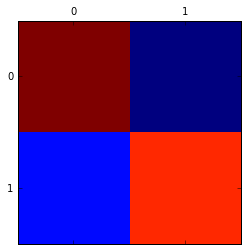

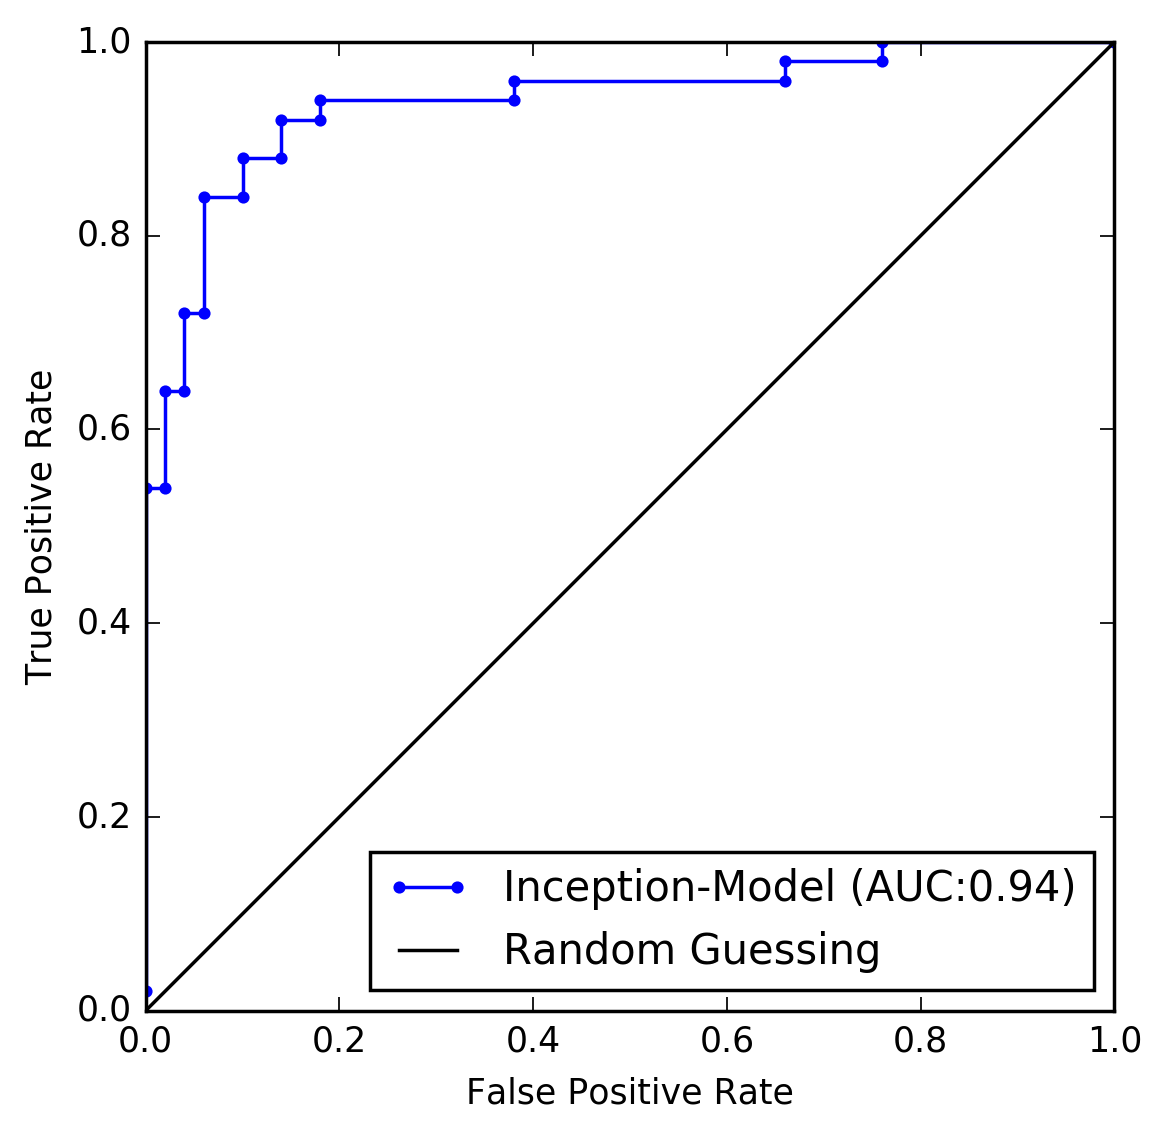

In [15]:
model = load_model('tb_model.h5')
test_dir = os.path.join(base_dir, 'chnmcu256test')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=671,
        class_mode='binary')

test_X, test_Y = next(test_generator)

pred_Y = model.predict(test_X, batch_size = 1, verbose = True)

from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y, pred_Y>0.5))
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Healthy', 'TB']))

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'Inception-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')


Found 671 images belonging to 2 classes.
671/671 [==============================] - 10s 15ms/step
             precision    recall  f1-score   support

    Healthy       0.80      0.79      0.80       389
         TB       0.72      0.73      0.73       282

avg / total       0.77      0.77      0.77       671



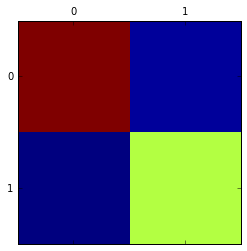

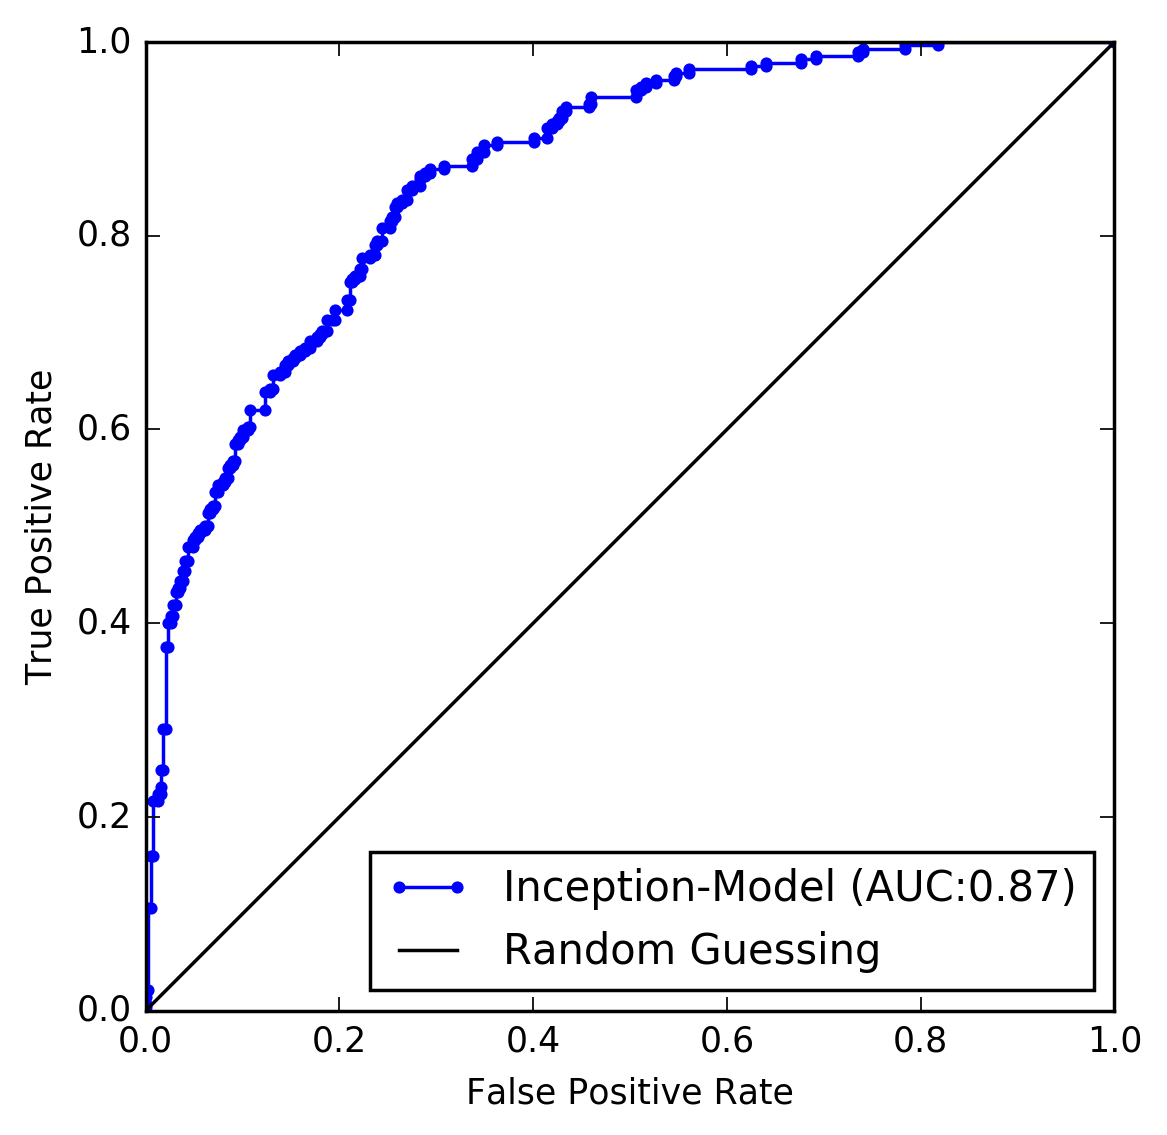

In [16]:
test_dir = os.path.join(base_dir, 'chnmcu256test')
test_dir = '/mnt/data/datasets/belnormtest'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=671,
        class_mode='binary')

test_X, test_Y = next(test_generator)

pred_Y = model.predict(test_X, batch_size = 1, verbose = True)

from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y, pred_Y>0.5))
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Healthy', 'TB']))

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'Inception-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')


## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [17]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)